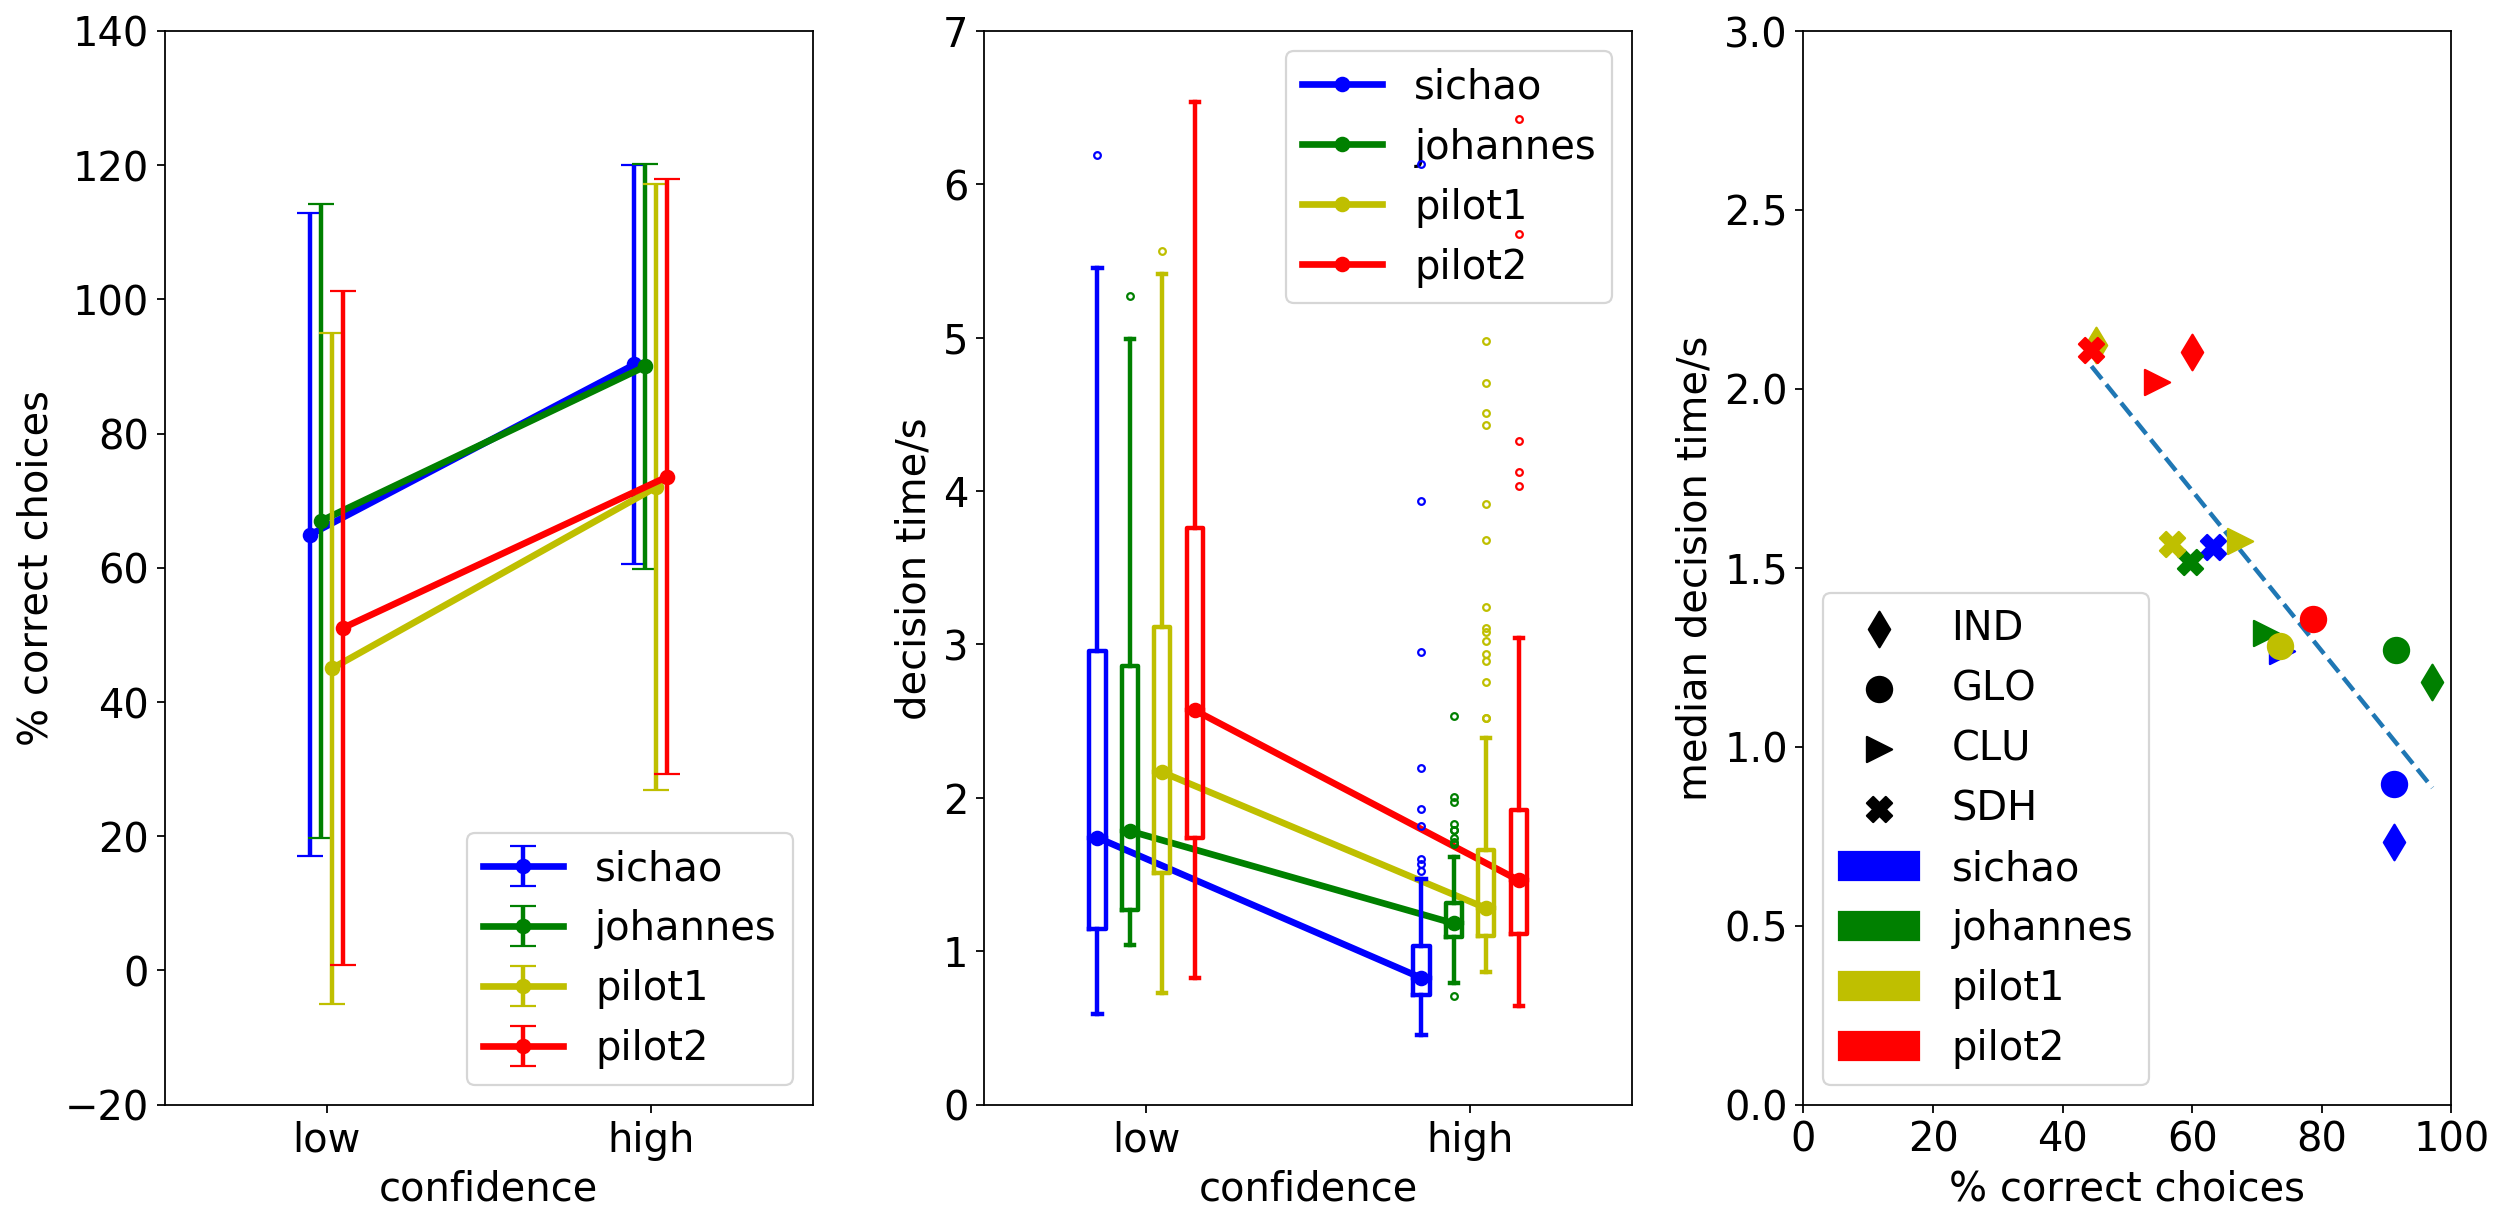

In [2]:
from analysis.data_analysis import plot_accuracy_confidence, plot_rt_confidence, plot_rt_accuracy
import matplotlib.pyplot as plt
dat_files = [
    '../data/exp1/sichao_0806/sichao_0806.dat',
    '../data/exp1/johannes_0805/johannes_0805.dat',
    '../data/exp1/pilot1_0806/pilot1_0806.dat',
    '../data/exp1/pilot2_0808/pilot2_0808.dat',
]
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 8), dpi=160)
plt.sca(axes[0])
plot_accuracy_confidence(dat_files, axes[0])
plt.sca(axes[1])
plot_rt_confidence(dat_files, axes[1])
plt.sca(axes[2])
plot_rt_accuracy(dat_files, axes[2])
plt.tight_layout()
plt.show()

In [13]:
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
from analysis.data_analysis import apply_Kalman_filters_on_exp2
from scipy.special import logsumexp, expit
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import numpy as np
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 16})
dat_files = [
    '../data/exp2/johannes_0805/johannes_0805.dat',
    '../data/exp2/sichao_0806/sichao_0806.dat',
    '../data/exp2/pilot1_0806/pilot1_0806.dat',
    '../data/exp2/pilot2_0808/pilot2_0808.dat',
]
def logistic(x, β, b):
    return expit(β * (x + b))
def logistic_with_lapse(x, α, β, b):
    return α / 2 + (1 - α) * expit(β * (x + b))
def logistic_with_lapse2(x, β, b):
    return logistic_with_lapse(x, 0.1, β, b)

[ 0.0210019  -8.39200114]
[ 3.16611695e-03 -4.24101526e+01]
[ 8.45898937e-03 -1.59848089e+01]

[ 2.62581969e-02 -2.97761341e+01]
[1.05153349e-02 2.86759347e+01]
[ 0.01682732 -8.55313055]

[ 0.0186145  -9.45366638]
[ 1.19044160e-02 -4.06097654e+01]
[ 1.56459371e-02 -2.13124235e+01]

[0.0189655 1.3970341]
[5.21498787e-03 1.39987483e+02]
[1.37683026e-02 2.37062737e+01]



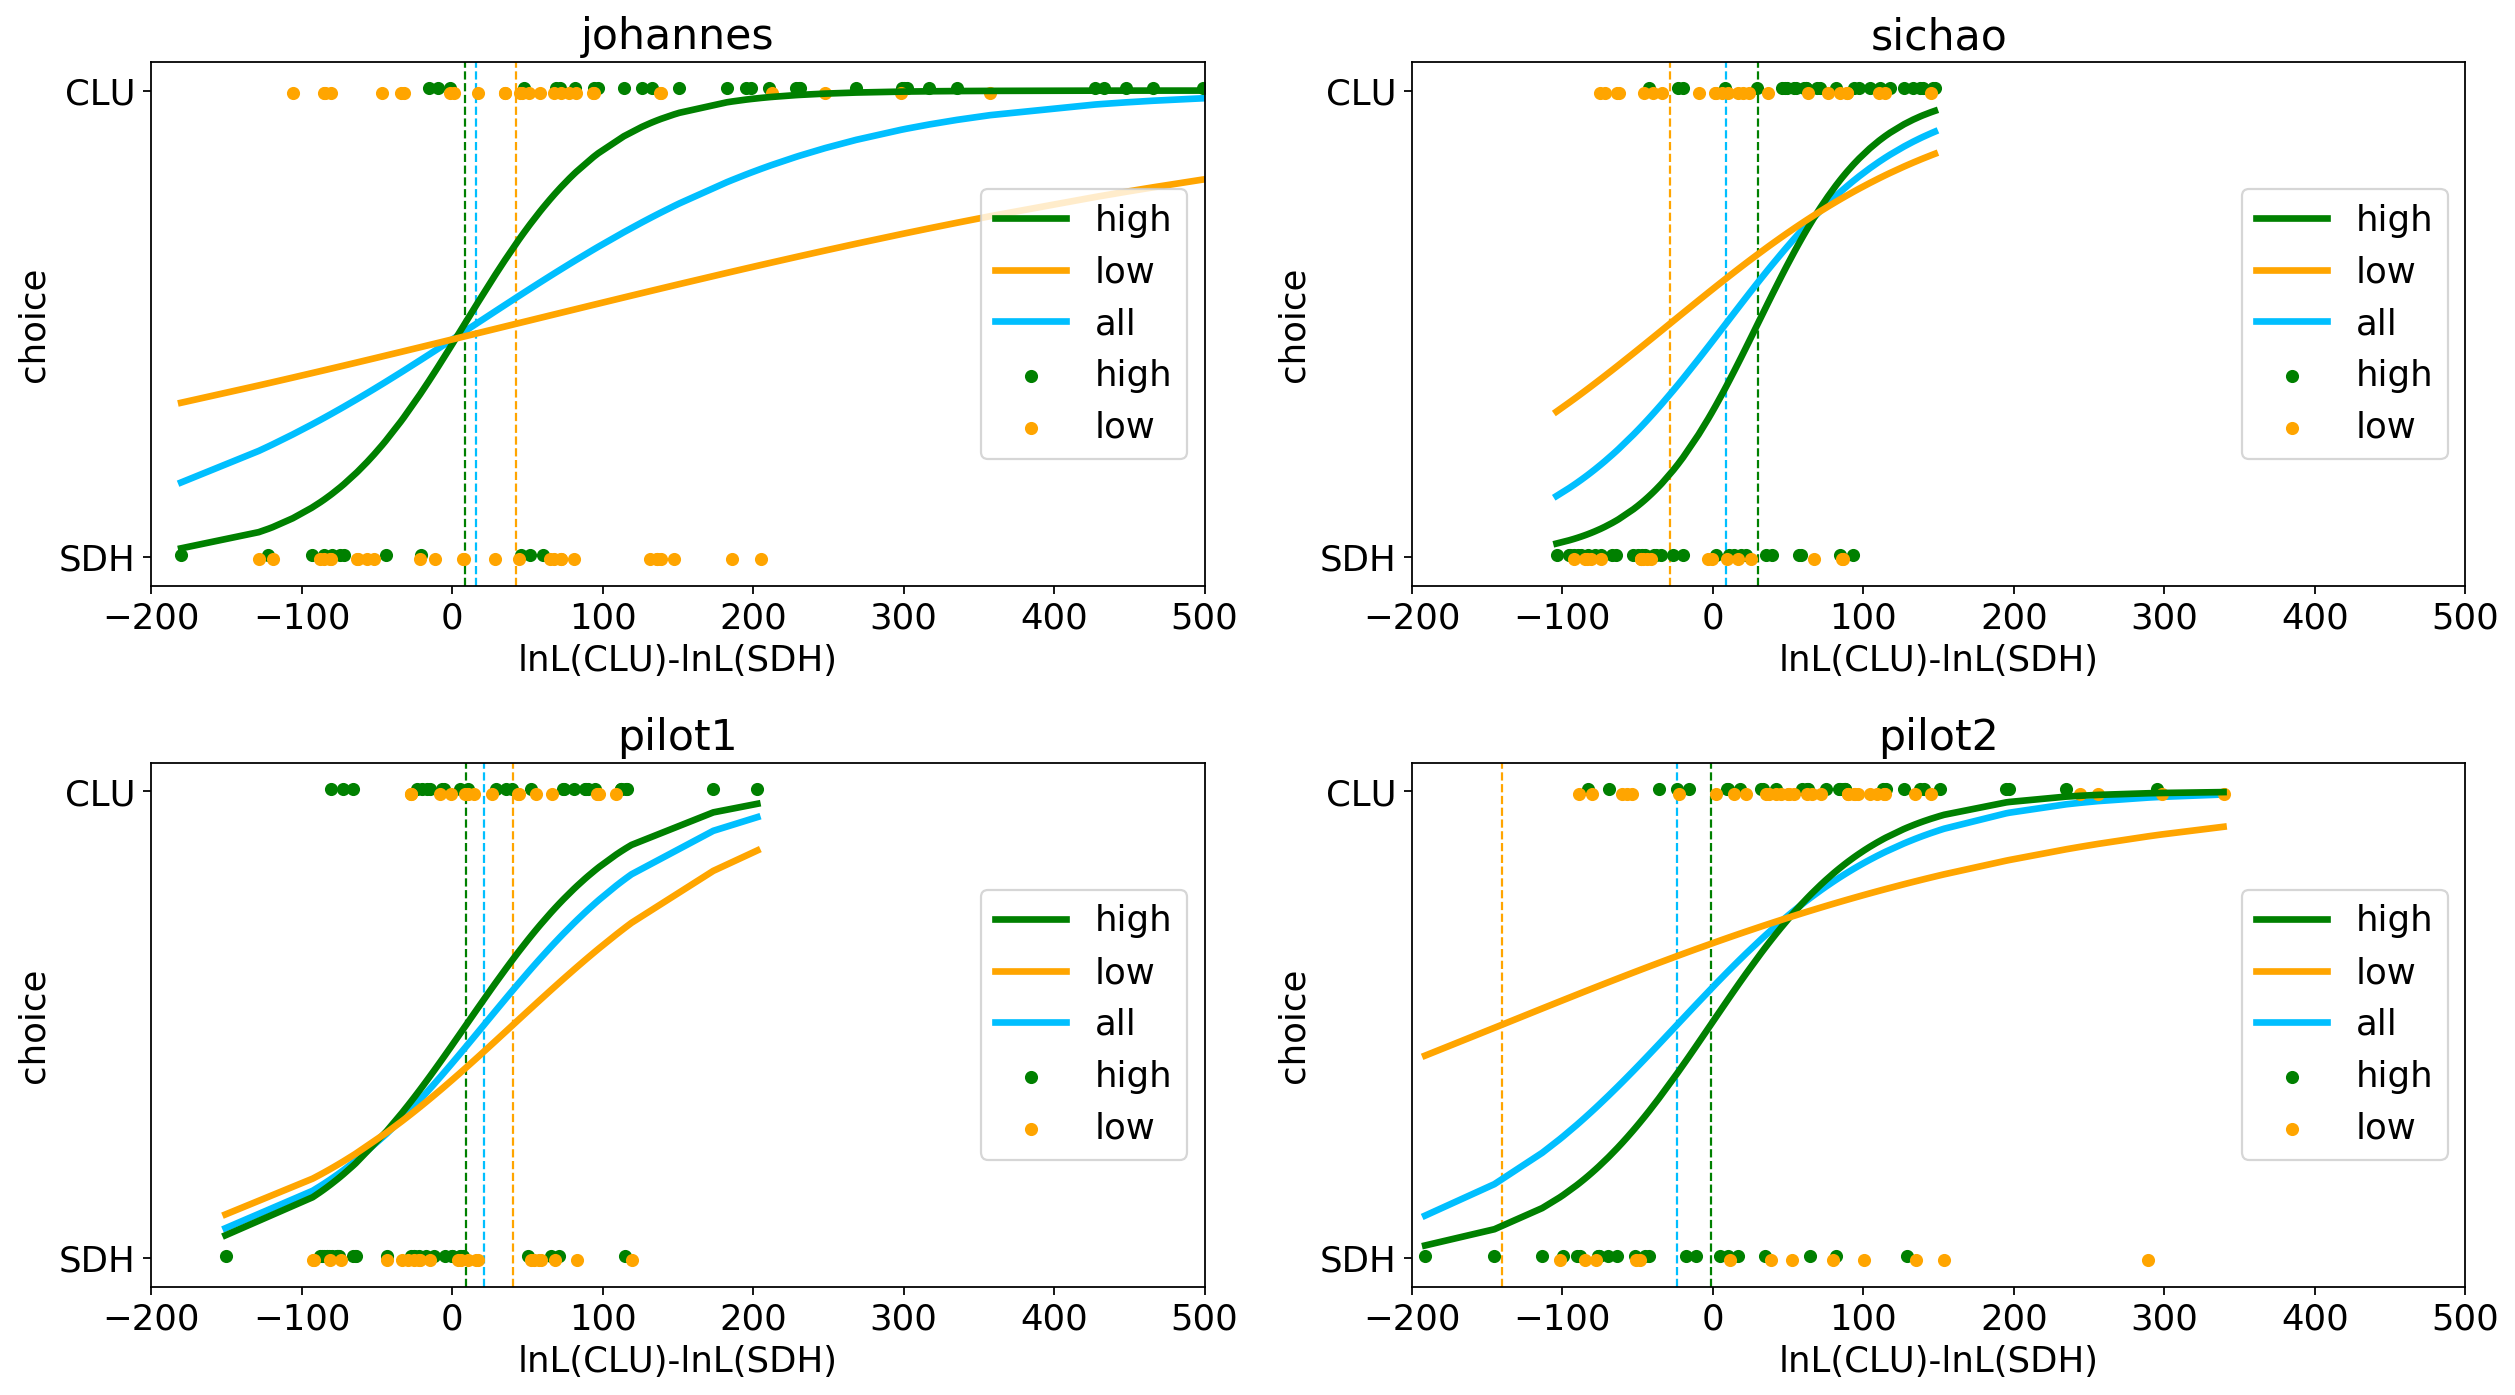

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), dpi=160)
for dat_file, ax in zip(dat_files, [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
    name = dat_file.split('/')[-1].split('_')[0]
    plt.sca(ax)
    ax.set_title(name)
    df = apply_Kalman_filters_on_exp2(dat_file)
    df['CLU'] = logsumexp(df[['CLU_012', 'CLU_120', 'CLU_201']], axis=1)
    df['SDH'] = logsumexp(df[['SDH_012', 'SDH_120', 'SDH_201']], axis=1)
    x = df['dL'] = df['CLU'] - df['SDH']
    y = df['choice'] = (df['choice'] == 'CLU') * 1. 
    order = np.argsort(x)
    x = x.to_numpy()[order]
    y = y.to_numpy()[order]
    groups = df.groupby('confidence')
    colors = {'high': mcd.CSS4_COLORS['green'], 'low': mcd.CSS4_COLORS['orange'], 'all': mcd.CSS4_COLORS['deepskyblue']}
    jitter = 0.005
    for c, group in groups:
        ax.scatter(group['dL'], group['choice'] + jitter, marker='o', s=24, label=c, color=colors[c])
        jitter = -jitter
        clf = LogisticRegression()
        xi, yi = group['dL'], group['choice']
        order = np.argsort(xi)
        xi = xi.to_numpy()[order]
        yi = yi.to_numpy()[order]
        popt, pcov = curve_fit(logistic, xi, yi, p0=[0.1, 1])
        print(popt)
        ax.plot(x, logistic(x, *popt), label=c, color=colors[c], linewidth=3)
        ax.axvline(-popt[1], ls='--', linewidth=1, zorder=-1, color=colors[c])
    popt, pcov = curve_fit(logistic, x, y)
    print(popt)
    print()
    c = 'all'
    ax.plot(x, logistic(x, *popt), linewidth=3, zorder=-1, label=c, color=colors[c])
    ax.axvline(-popt[1], ls='--', linewidth=1, zorder=-1, color=colors[c])
    ax.legend(loc='right')
    ax.set_xlim((-200, 500))
    ax.set_xlabel('lnL(CLU)-lnL(SDH)')
    ax.set_yticks([0,1])
    ax.set_yticklabels(['SDH', 'CLU'])
    ax.set_ylabel('choice')
plt.tight_layout()
plt.show()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 94.56058668236845
            Iterations: 18
            Function evaluations: 144
            Gradient evaluations: 18
     fun: 94.56058668236845
     jac: array([ 1.90734863e-05, -8.99124146e-03, -2.28881836e-04, -3.55434418e-03,
        2.75421143e-03])
 message: 'Optimization terminated successfully.'
    nfev: 144
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.001     ,  0.79460655, -0.20546111,  0.76441283,  0.41619702])
[0.82604789 1.23676993]
[0.24470152 1.55313213 1.26874174]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 123.274359023495
            Iterations: 19
            Function evaluations: 150
            Gradient evaluations: 19
     fun: 123.274359023495
     jac: array([-4.88281250e-03,  7.63607025e-03,  4.00543213e-05,  4.69207764e-04,
       -2.29835510e-04])
 message: 'Optimization terminated successfu

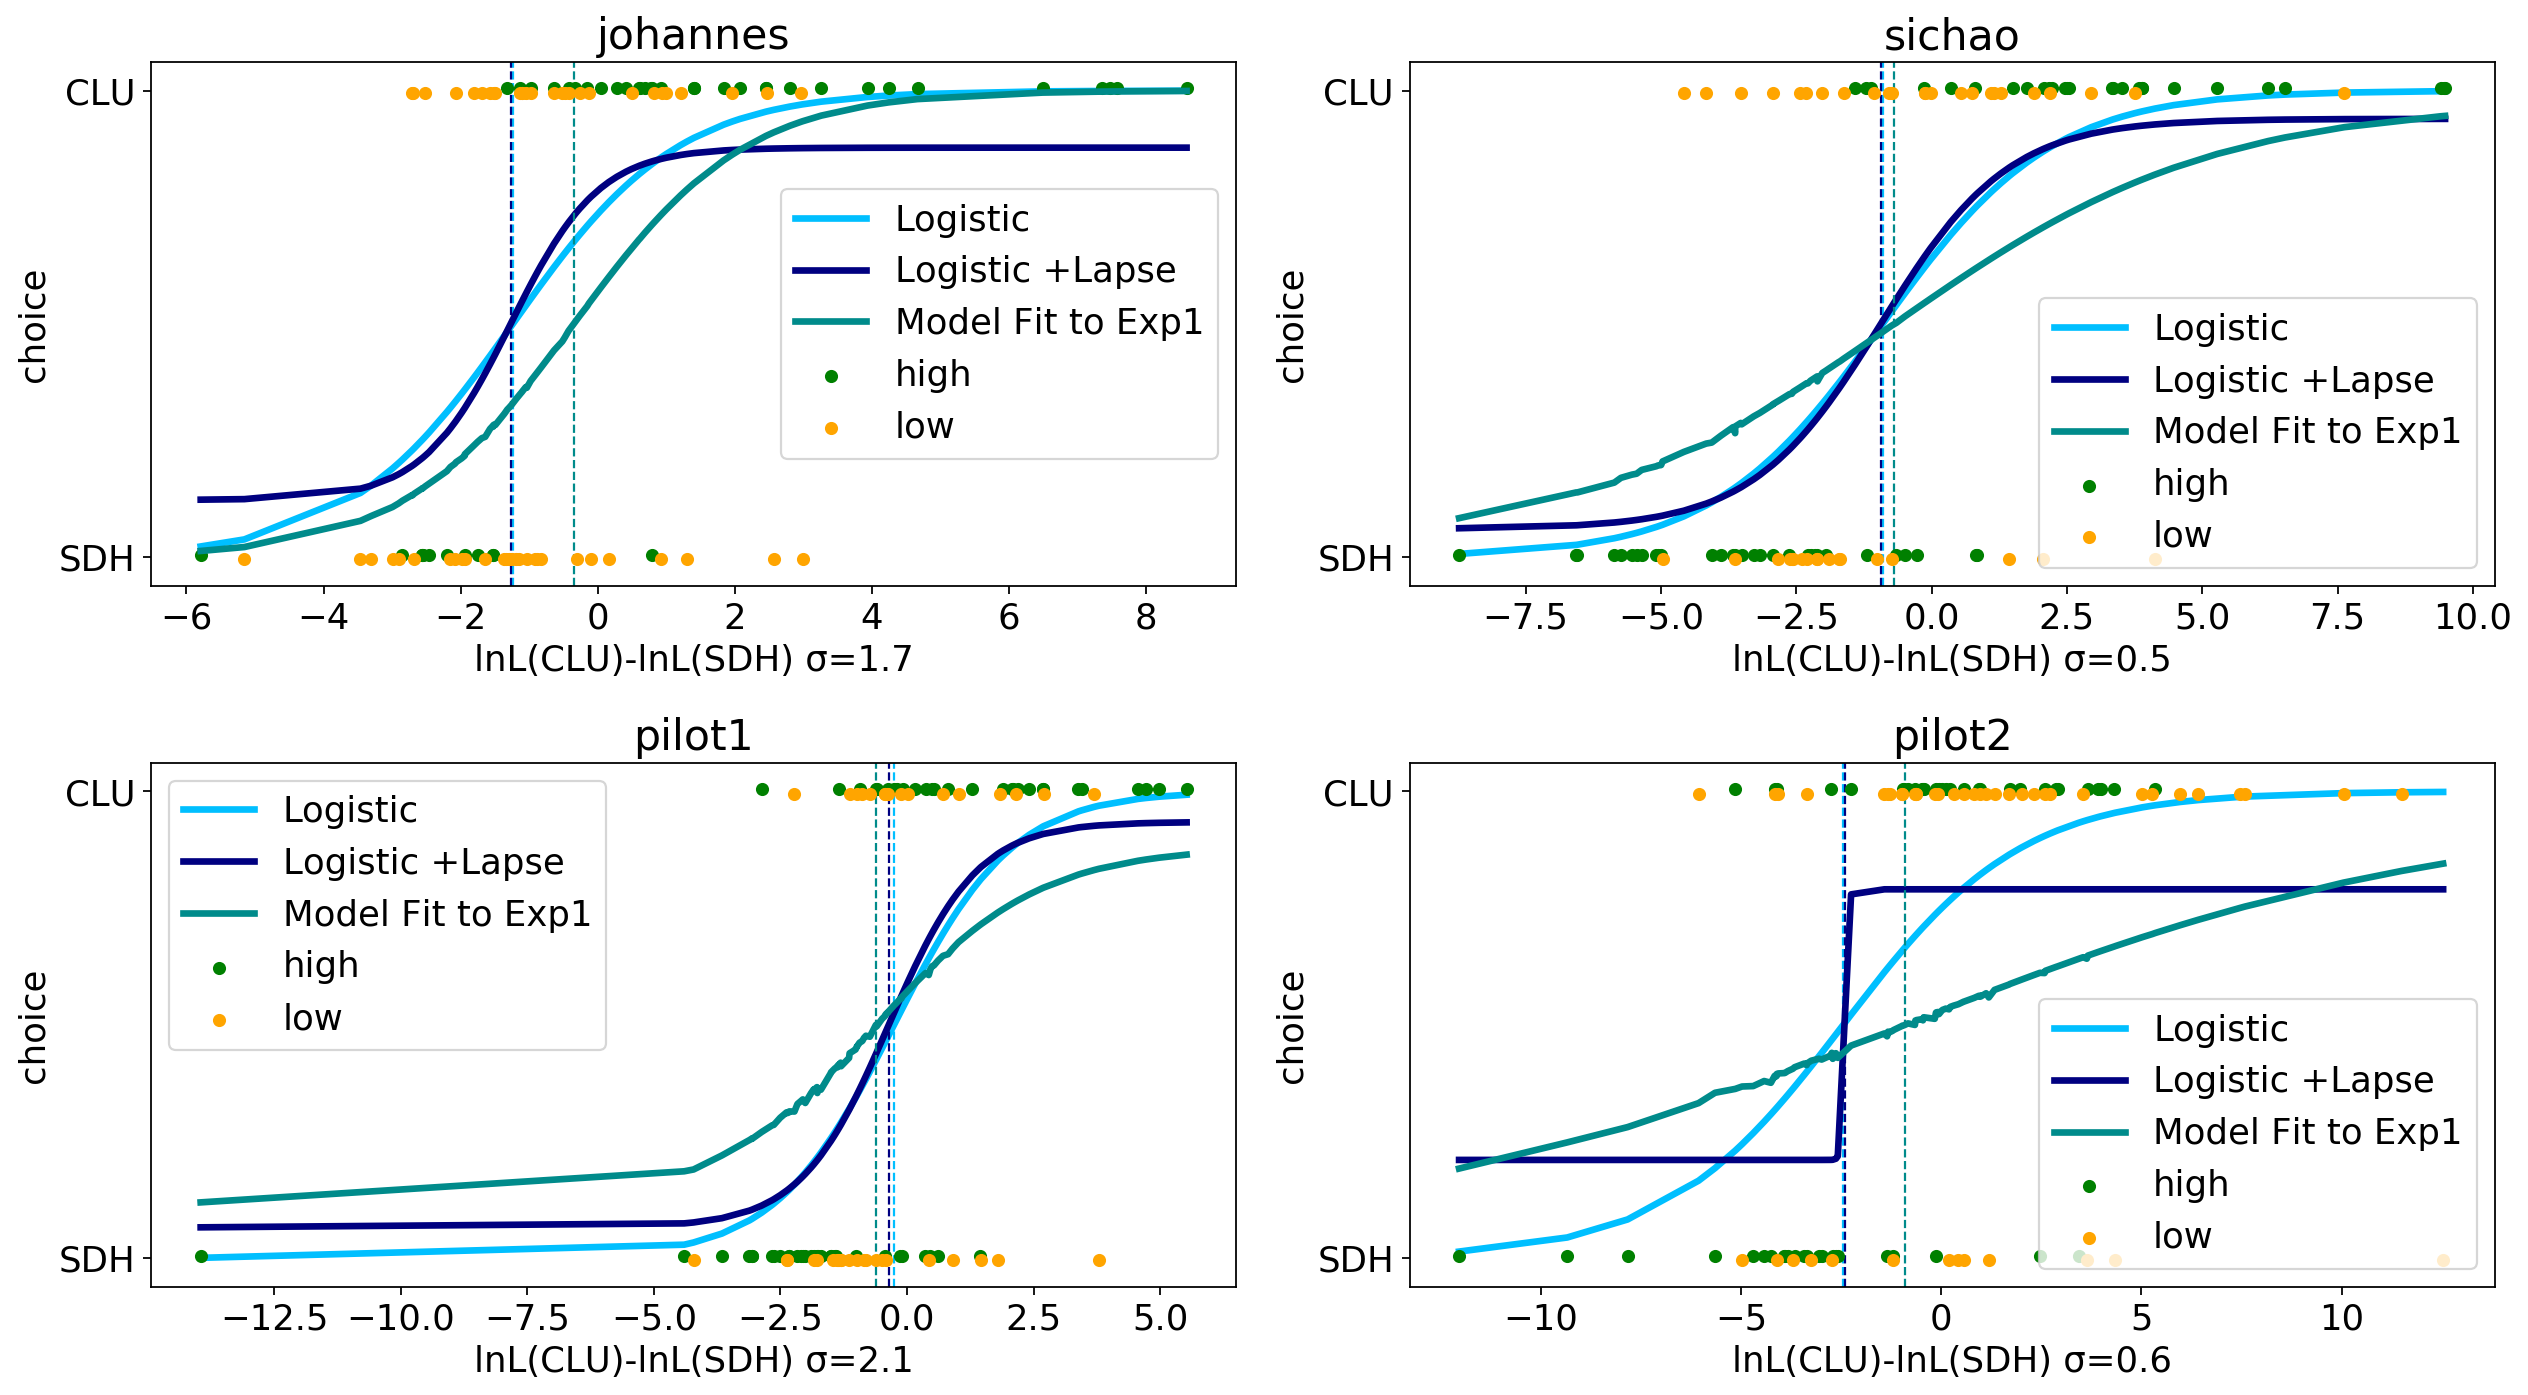

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), dpi=160)
σs = [1.7, 0.5, 2.1, 0.6]
for dat_file, ax, σ_R in zip(dat_files, [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]], σs):
    name = dat_file.split('/')[-1].split('_')[0]
    plt.sca(ax)
    ax.set_title(name)
    df = apply_Kalman_filters_on_exp2(dat_file, σ_R=σ_R)
    col_structures = ['CLU_012', 'CLU_120', 'CLU_201', 'SDH_012', 'SDH_120', 'SDH_201']
    structures = ['CLU', 'CLU', 'CLU', 'SDH', 'SDH', 'SDH']
    from analysis.model import StructureDecisionModel
    from analysis.data_analysis import param_extractor_exp2, bounds_exp2, fit_model_to_exp1
    model = StructureDecisionModel(
        df=df,
        col_target='choice', col_structures=col_structures, structures=structures,
        param_extractor=param_extractor_exp2, bounds=bounds_exp2(), normalize=False
    )
    res = fit_model_to_exp1(dat_file.replace('exp2', 'exp1'), np.array([[0.1, 0.1, 0, 0, 0]]), σ_R=σ_R)
    𝜃 = res.x
    p = model.predict(np.array([𝜃[0], 𝜃[1], 𝜃[-1] - 𝜃[-2]]))
    df['p_CLU'] = np.sum(p[:, :3], axis=1)
    df['p_SDH'] = np.sum(p[:, 3:], axis=1)
    df['CLU'] = logsumexp(df[['CLU_012', 'CLU_120', 'CLU_201']], axis=1)
    df['SDH'] = logsumexp(df[['SDH_012', 'SDH_120', 'SDH_201']], axis=1)
    x = df['dL'] = df['CLU'] - df['SDH']
    y = df['choice'] = (df['choice'] == 'CLU') * 1. 
    order = np.argsort(x)
    x = x.to_numpy()[order]
    y = y.to_numpy()[order]
    y_pred = df['p_CLU'].to_numpy()[order]
    groups = df.groupby('confidence')
    colors = {'high': mcd.CSS4_COLORS['green'], 'low': mcd.CSS4_COLORS['orange'], 
              'Logistic': mcd.CSS4_COLORS['deepskyblue'],
              'Logistic +Lapse': mcd.CSS4_COLORS['navy'],
              'Model Fit to Exp1': mcd.CSS4_COLORS['darkcyan']}
    jitter = 0.005
    for c, group in groups:
        ax.scatter(group['dL'], group['choice'] + jitter, marker='o', s=24, label=c, color=colors[c])
        jitter = -jitter
    popt, pcov = curve_fit(logistic, x, y, p0=[0.1, 0])
    print(popt)
    c = 'Logistic'
    ax.plot(x, logistic(x, *popt), linewidth=3, zorder=-1, label=c, color=colors[c])
    ax.axvline(-popt[1], ls='--', linewidth=1, zorder=-1, color=colors[c])
    popt, pcov = curve_fit(logistic_with_lapse, x, y, p0=[0.1, 0.1, 0])
    print(popt)
    c = 'Logistic +Lapse'
    ax.plot(x, logistic_with_lapse(x, *popt), linewidth=3, zorder=-1, label=c, color=colors[c])
    ax.axvline(-popt[2], ls='--', linewidth=1, zorder=-1, color=colors[c])
    print()
    c = 'Model Fit to Exp1'
    ax.plot(x, y_pred, label=c, color=colors[c], linewidth=3)
    ax.axvline(𝜃[-1] - 𝜃[-2], ls='--', linewidth=1, zorder=-1, color=colors[c])
    ax.legend()
    ax.set_xlabel(f'lnL(CLU)-lnL(SDH) σ={σ_R}')
    ax.set_yticks([0,1])
    ax.set_yticklabels(['SDH', 'CLU'])
    ax.set_ylabel('choice')
plt.tight_layout()
plt.show()

[ 2.60773928e-05 -3.24206808e+04]

Optimization terminated successfully.
         Current function value: 0.653342
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Tue, 13 Aug 2019   Pseudo R-squ.:                 0.04751
Time:                        01:29:55   Log-Likelihood:                -65.334
converged:                       True   LL-Null:                       -68.593
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.089e-05   4.98e-06      2.188      0.029    1.13e-06    2.0

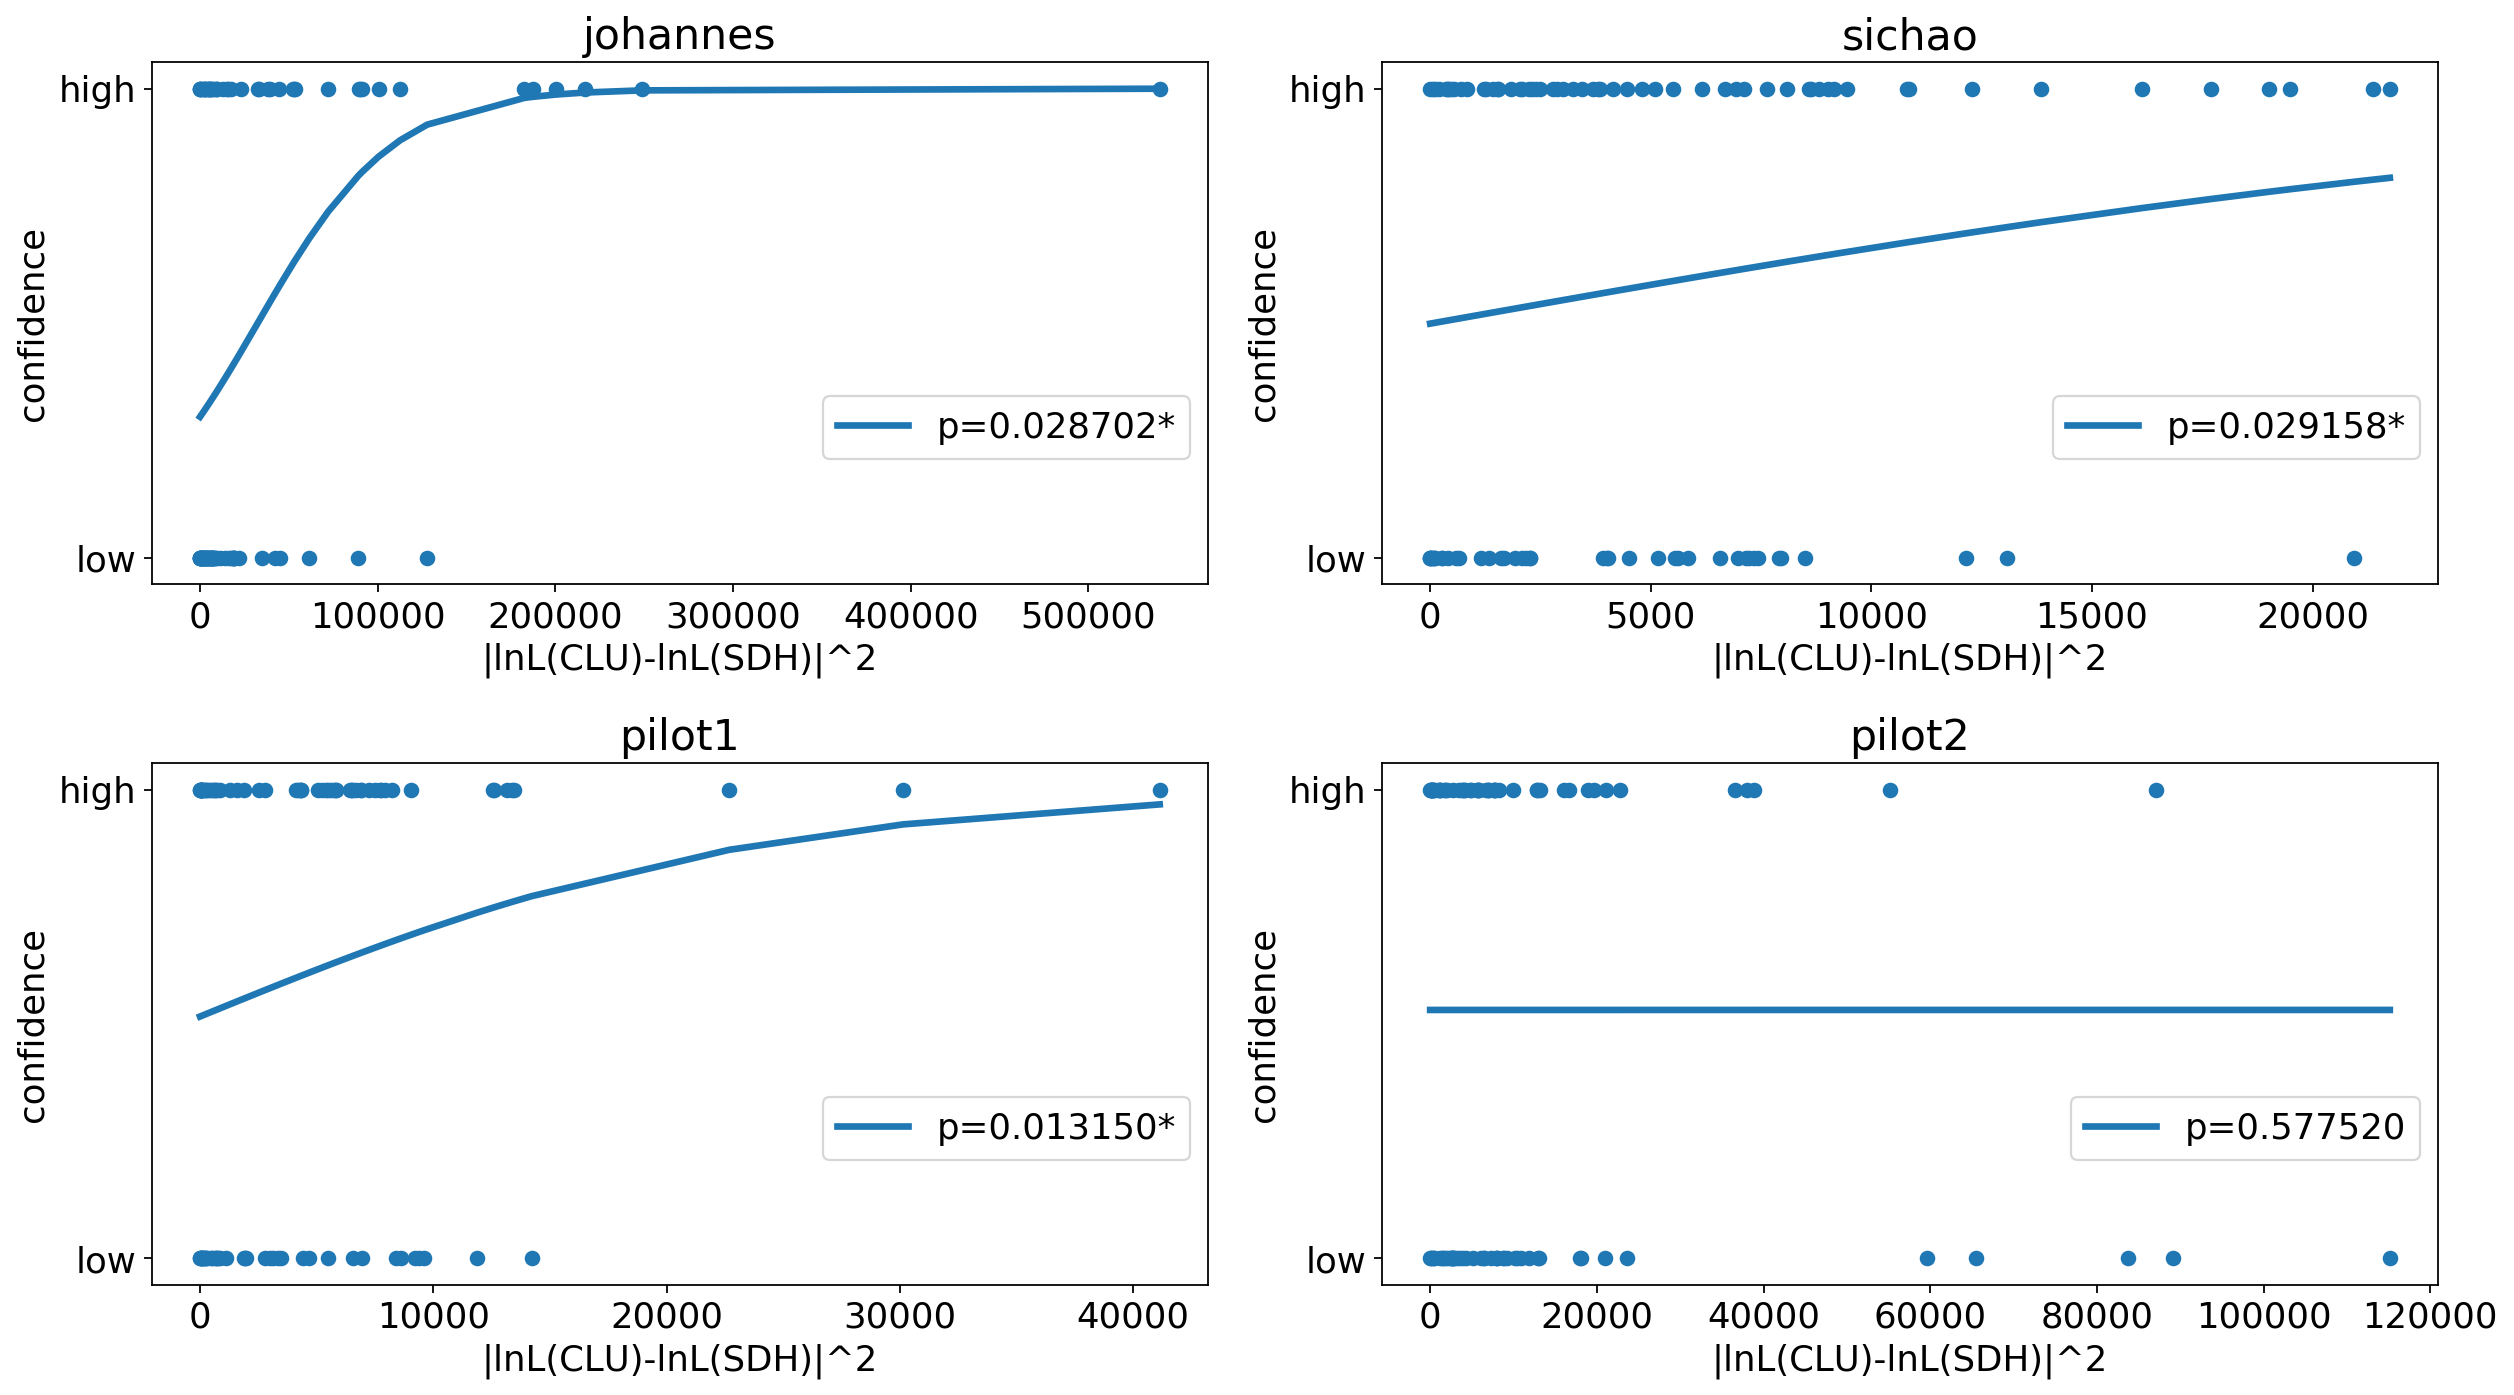

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), dpi=160)
for dat_file, ax in zip(dat_files, [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
    name = dat_file.split('/')[-1].split('_')[0]
    plt.sca(ax)
    ax.set_title(name)
    df = apply_Kalman_filters_on_exp2(dat_file)
    df['CLU'] = logsumexp(df[['CLU_012', 'CLU_120', 'CLU_201']], axis=1)
    df['SDH'] = logsumexp(df[['SDH_012', 'SDH_120', 'SDH_201']], axis=1)
    x = df['dL'] = np.abs(df['CLU'] - df['SDH']) ** 2
    y = df['confidence'] = (df['confidence'] == 'high') * 1. 
    order = np.argsort(x)
    x = x.to_numpy()[order]
    y = y.to_numpy()[order]
    popt, pcov = curve_fit(logistic, x, y, p0=(0.01, -10), bounds=([0, -np.inf], [np.inf, np.inf]))
    print(popt)
    print()
    ax.scatter(x, y)
    res = sm.Logit(y, x).fit()
    print(res.summary())
    pvalue = res.pvalues[0]
    ax.plot(x, logistic(x, *popt), linewidth=3, label=f"p={pvalue:.6f}{'*' if pvalue < 0.05 else ''}")
    # ax.axvline(-popt[1], ls='--', linewidth=1)
    ax.legend(bbox_to_anchor=(1, 0.3), loc='center right')
    # ax.set_xlim((0, 500))
    ax.set_xlabel('|lnL(CLU)-lnL(SDH)|^2')
    ax.set_yticks([0,1])
    ax.set_yticklabels(['low', 'high'])
    ax.set_ylabel('confidence')
plt.tight_layout()
plt.show()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 101.47286885930114
            Iterations: 16
            Function evaluations: 110
            Gradient evaluations: 16
     fun: 101.47286885930114
     jac: array([ 0.        ,  0.00576591, -0.00138855,  0.00248909])
 message: 'Optimization terminated successfully.'
    nfev: 110
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.1       , 0.76932827, 1.51296966, 1.22175825])
[0.81095577 1.35379097]
[1.03548221 1.37844834]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 134.2599031927605
            Iterations: 19
            Function evaluations: 129
            Gradient evaluations: 19
     fun: 134.2599031927605
     jac: array([ 0.        , -0.00625801, -0.00110817,  0.00037956])
 message: 'Optimization terminated successfully.'
    nfev: 129
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([0.1       , 0.

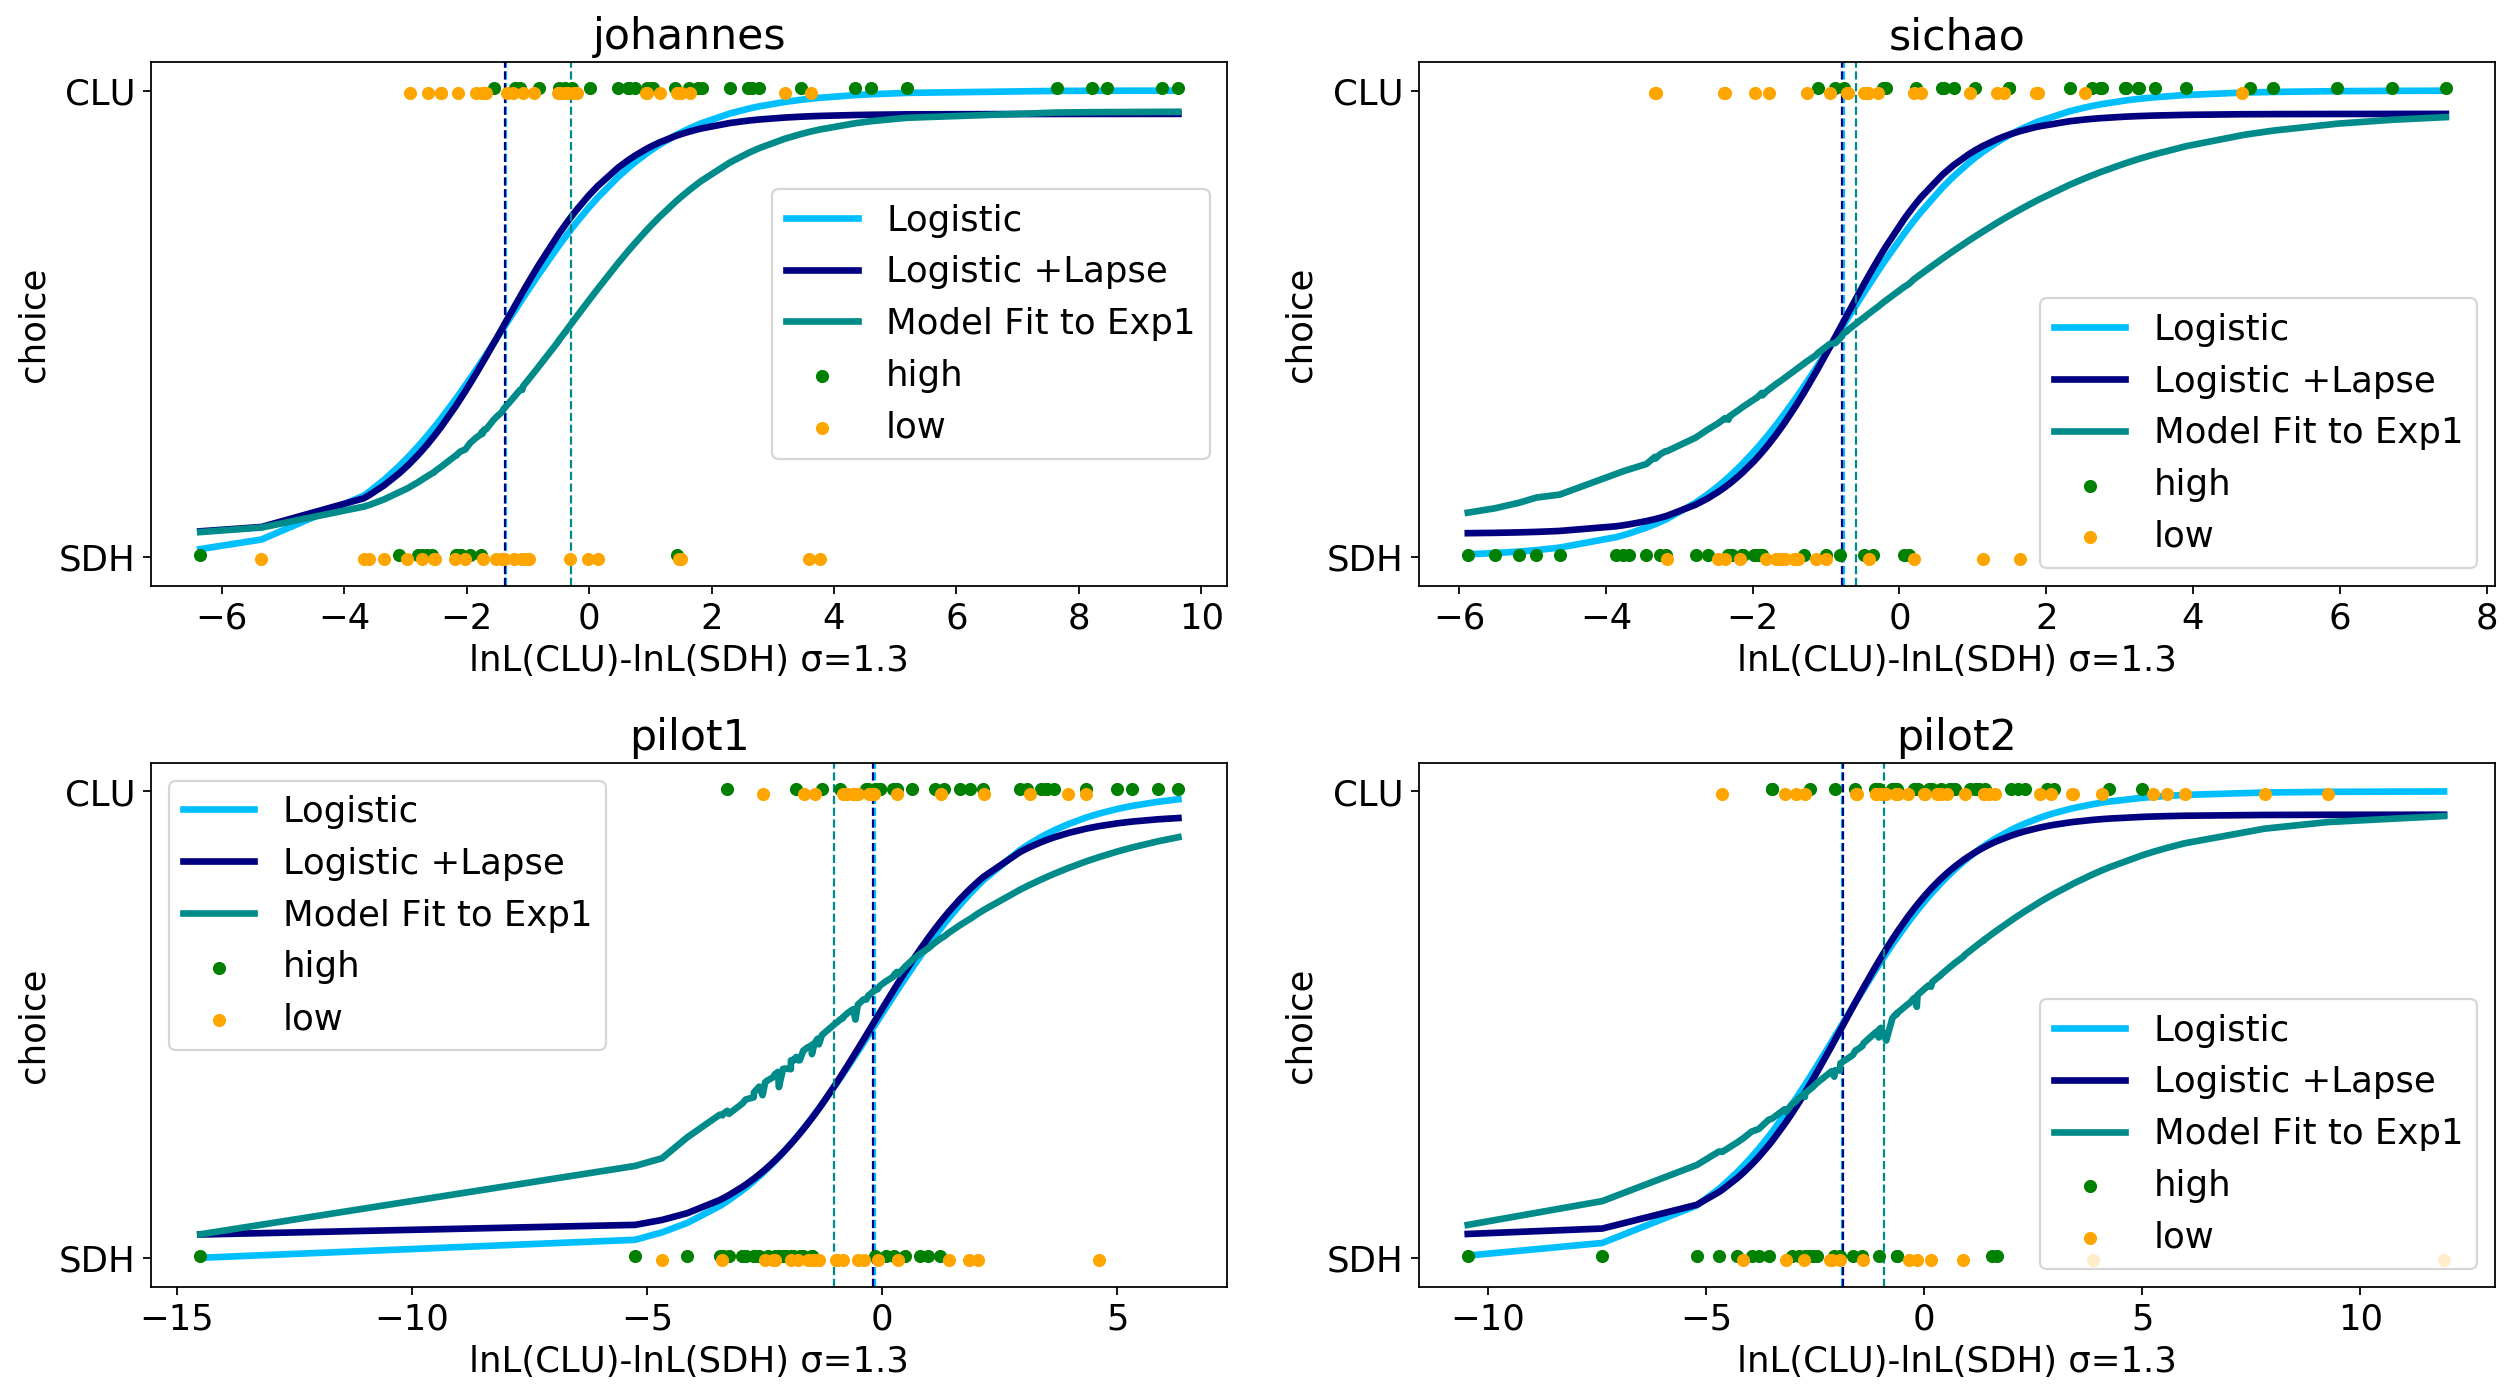

In [16]:
def param_extractor(𝜃):
    from scipy.stats import expon
    α = np.linspace(0, 1, 50)
    pα = expon.pdf(α, scale=0.1)
    pα = pα / pα.sum()
    A = [(α[i], pα[i]) for i in range(len(α))]
    β = 𝜃[1]
    b = np.array([0, 𝜃[-3]] + [𝜃[-2]] * 3 + [𝜃[-1]] * 3)
    return A, β, b

def bounds():
    return [(0., None), (None, None), (None, None), (None, None)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), dpi=160)
σ_R = 1.3
for dat_file, ax in zip(dat_files, [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
    name = dat_file.split('/')[-1].split('_')[0]
    plt.sca(ax)
    ax.set_title(name)
    df = apply_Kalman_filters_on_exp2(dat_file, σ_R=σ_R)
    col_structures = ['CLU_012', 'CLU_120', 'CLU_201', 'SDH_012', 'SDH_120', 'SDH_201']
    structures = ['CLU', 'CLU', 'CLU', 'SDH', 'SDH', 'SDH']
    from analysis.model import StructureDecisionModel
    from analysis.data_analysis import param_extractor_exp2, bounds_exp2, fit_model_to_exp1
    model = StructureDecisionModel(
        df=df,
        col_target='choice', col_structures=col_structures, structures=structures,
        param_extractor=param_extractor_exp2, bounds=bounds_exp2(), normalize=False
    )
    res = fit_model_to_exp1(dat_file.replace('exp2', 'exp1'), np.array([[0.1, 0, 0, 0]]), σ_R=σ_R,
                            param_extractor=param_extractor, bounds=bounds)
    𝜃 = res.x
    p = model.predict(np.array([𝜃[0], 𝜃[1], 𝜃[-1] - 𝜃[-2]]))
    df['p_CLU'] = np.sum(p[:, :3], axis=1)
    df['p_SDH'] = np.sum(p[:, 3:], axis=1)
    df['CLU'] = logsumexp(df[['CLU_012', 'CLU_120', 'CLU_201']], axis=1)
    df['SDH'] = logsumexp(df[['SDH_012', 'SDH_120', 'SDH_201']], axis=1)
    x = df['dL'] = df['CLU'] - df['SDH']
    y = df['choice'] = (df['choice'] == 'CLU') * 1. 
    order = np.argsort(x)
    x = x.to_numpy()[order]
    y = y.to_numpy()[order]
    y_pred = df['p_CLU'].to_numpy()[order]
    groups = df.groupby('confidence')
    colors = {'high': mcd.CSS4_COLORS['green'], 'low': mcd.CSS4_COLORS['orange'], 
              'Logistic': mcd.CSS4_COLORS['deepskyblue'],
              'Logistic +Lapse': mcd.CSS4_COLORS['navy'],
              'Model Fit to Exp1': mcd.CSS4_COLORS['darkcyan']}
    jitter = 0.005
    for c, group in groups:
        ax.scatter(group['dL'], group['choice'] + jitter, marker='o', s=24, label=c, color=colors[c])
        jitter = -jitter
    popt, pcov = curve_fit(logistic, x, y, p0=[0.1, 0])
    print(popt)
    c = 'Logistic'
    ax.plot(x, logistic(x, *popt), linewidth=3, zorder=-1, label=c, color=colors[c])
    ax.axvline(-popt[1], ls='--', linewidth=1, zorder=-1, color=colors[c])
    popt, pcov = curve_fit(logistic_with_lapse2, x, y, p0=[0.1, 0])
    print(popt)
    c = 'Logistic +Lapse'
    ax.plot(x, logistic_with_lapse2(x, *popt), linewidth=3, zorder=-1, label=c, color=colors[c])
    ax.axvline(-popt[1], ls='--', linewidth=1, zorder=-1, color=colors[c])
    print()
    c = 'Model Fit to Exp1'
    ax.plot(x, y_pred, label=c, color=colors[c], linewidth=3)
    ax.axvline(𝜃[-1] - 𝜃[-2], ls='--', linewidth=1, zorder=-1, color=colors[c])
    ax.legend()
    ax.set_xlabel(f'lnL(CLU)-lnL(SDH) σ={σ_R}')
    ax.set_yticks([0,1])
    ax.set_yticklabels(['SDH', 'CLU'])
    ax.set_ylabel('choice')
plt.tight_layout()
plt.show()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.82105406851072
            Iterations: 24
            Function evaluations: 186
            Gradient evaluations: 24
     fun: 95.82105406851072
     jac: array([ 8.40473175e-03,  1.27124786e-03,  7.62939453e-05, -5.81741333e-05,
       -2.86102295e-06])
 message: 'Optimization terminated successfully.'
    nfev: 186
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([0.0015914 , 0.64253081, 0.83524059, 1.58490442, 1.25566357])
[0.81095577 1.35379097]
[1.03548221 1.37844834]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 128.9455479701899
            Iterations: 18
            Function evaluations: 144
            Gradient evaluations: 18
     fun: 128.9455479701899
     jac: array([ 0.00022125, -0.00466347,  0.00011444,  0.00237846, -0.00262833])
 message: 'Optimization terminated successfully.'
    nfev: 144
     nit: 18
    njev

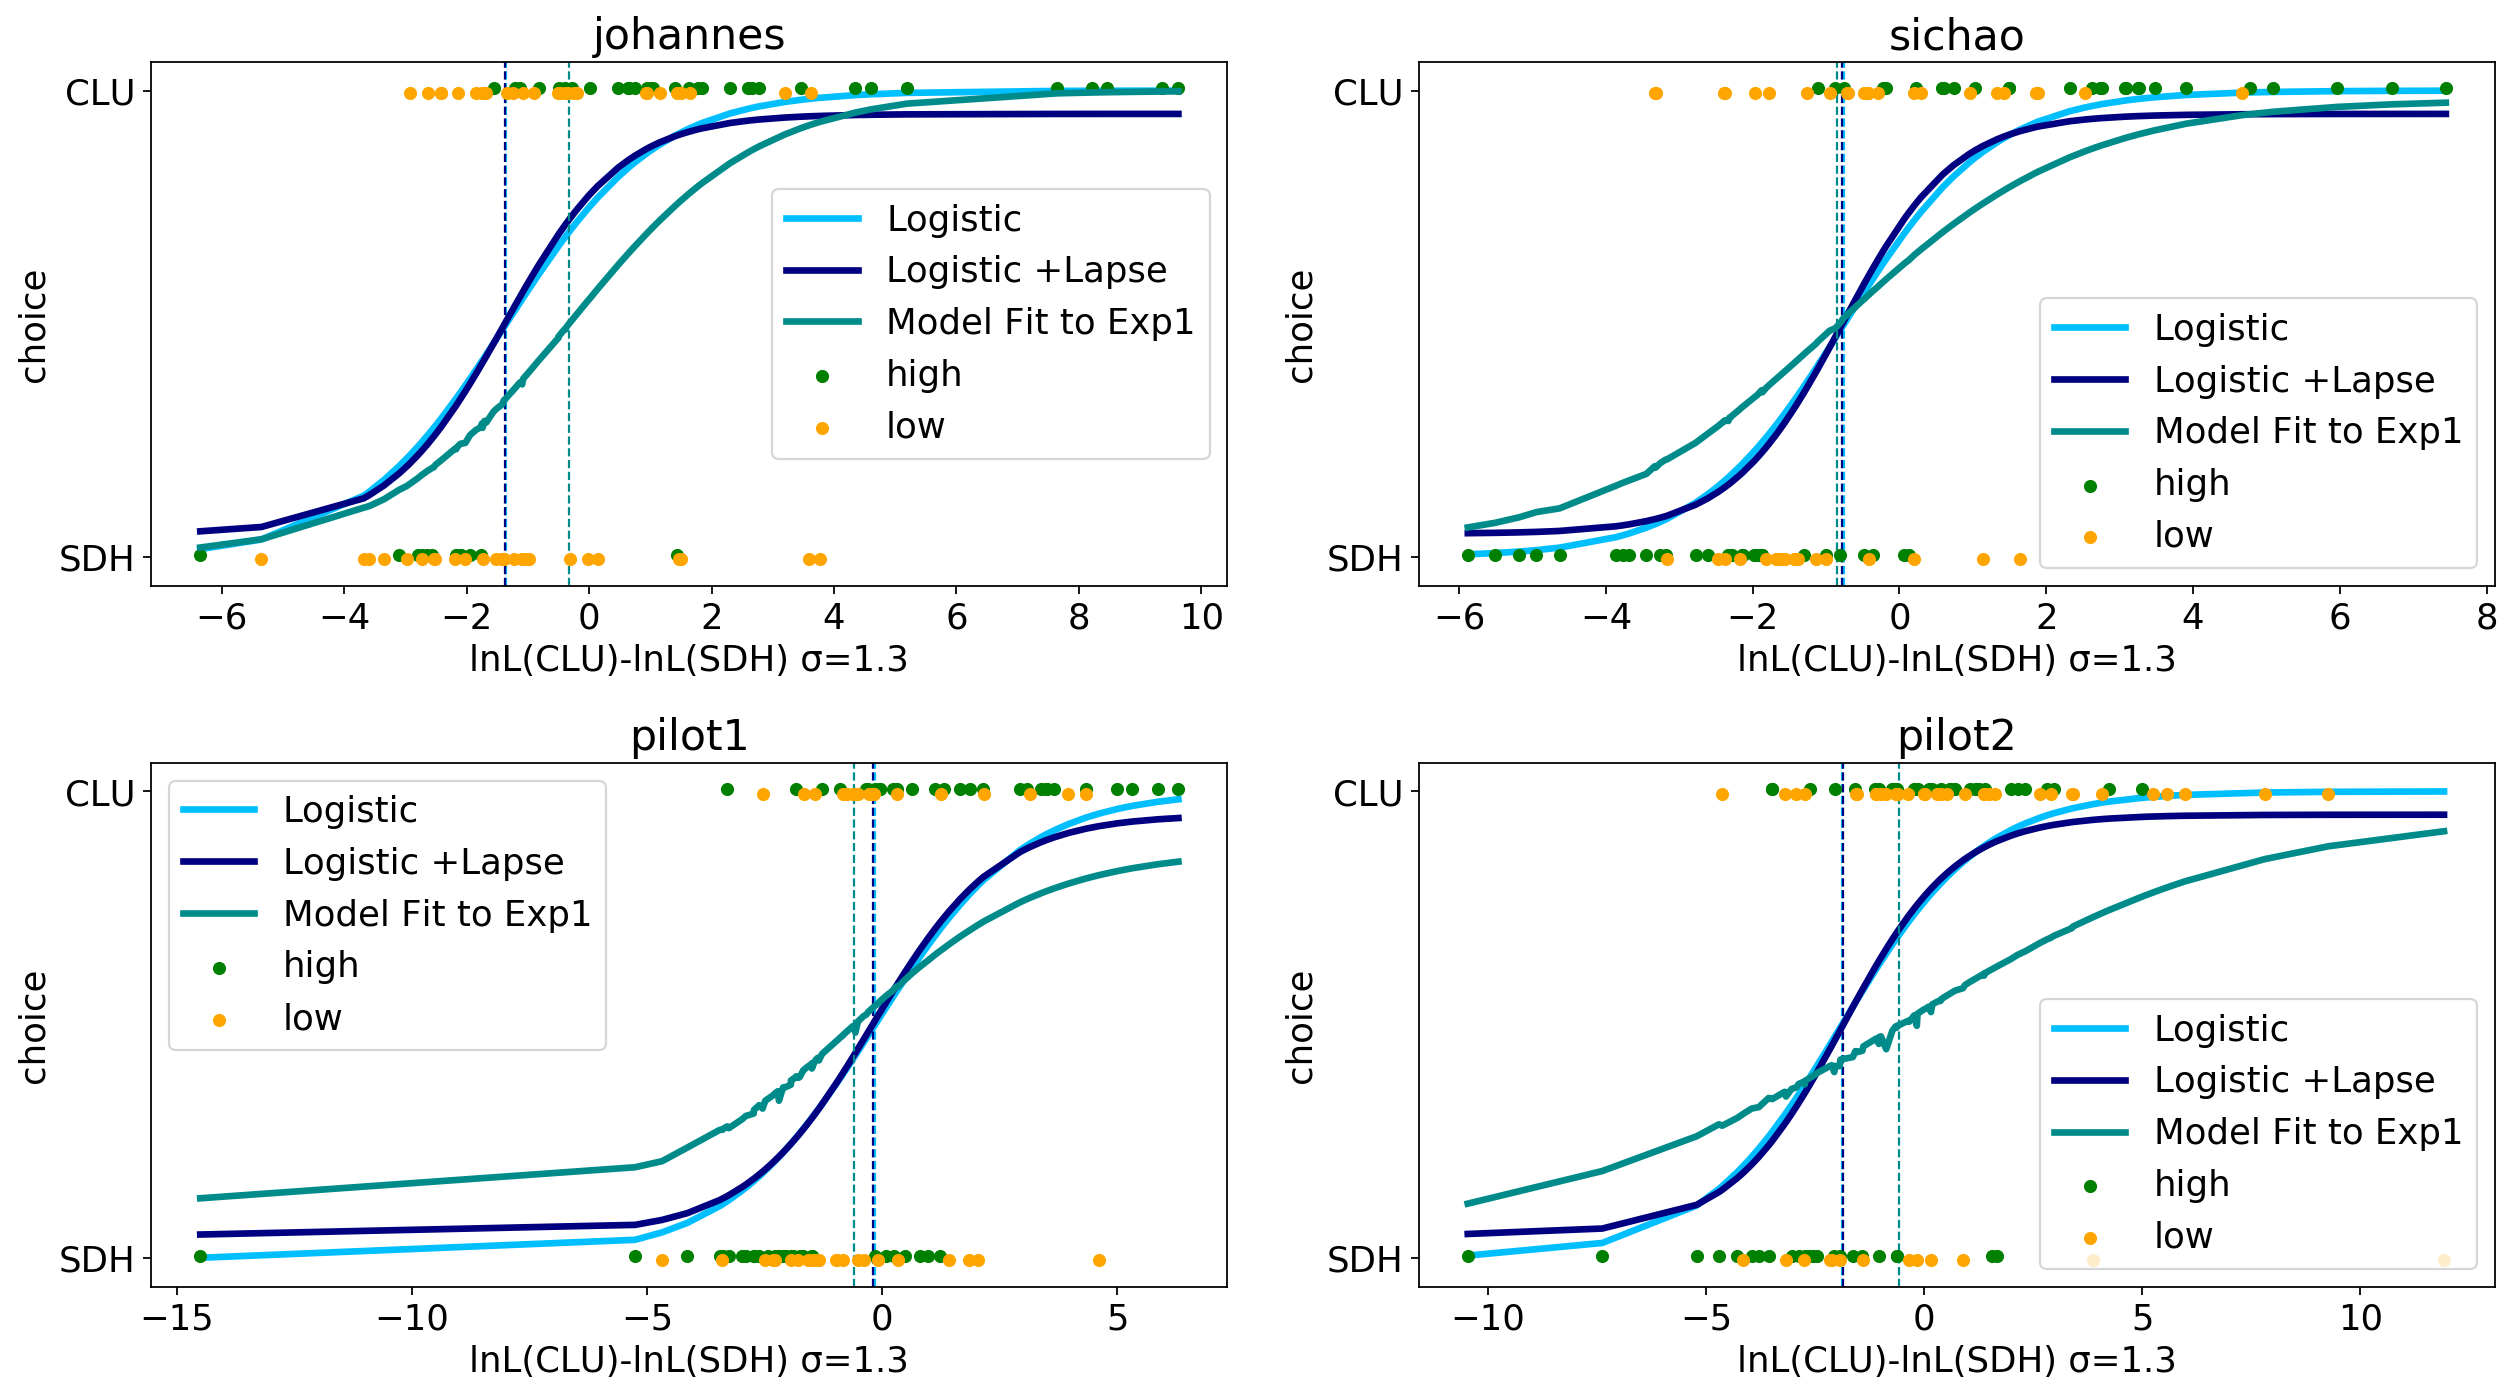

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), dpi=160)
σ_R = 1.3
for dat_file, ax in zip(dat_files, [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
    name = dat_file.split('/')[-1].split('_')[0]
    plt.sca(ax)
    ax.set_title(name)
    df = apply_Kalman_filters_on_exp2(dat_file, σ_R=σ_R)
    col_structures = ['CLU_012', 'CLU_120', 'CLU_201', 'SDH_012', 'SDH_120', 'SDH_201']
    structures = ['CLU', 'CLU', 'CLU', 'SDH', 'SDH', 'SDH']
    from analysis.model import StructureDecisionModel
    from analysis.data_analysis import param_extractor_exp2, bounds_exp2, fit_model_to_exp1
    model = StructureDecisionModel(
        df=df,
        col_target='choice', col_structures=col_structures, structures=structures,
        param_extractor=param_extractor_exp2, bounds=bounds_exp2(), normalize=False
    )
    res = fit_model_to_exp1(dat_file.replace('exp2', 'exp1'), np.array([[0.1, 0.1, 0, 0, 0]]), σ_R=σ_R,
                            )
    𝜃 = res.x
    p = model.predict(np.array([𝜃[0], 𝜃[1], 𝜃[-1] - 𝜃[-2]]))
    df['p_CLU'] = np.sum(p[:, :3], axis=1)
    df['p_SDH'] = np.sum(p[:, 3:], axis=1)
    
    df['CLU'] = logsumexp(df[['CLU_012', 'CLU_120', 'CLU_201']], axis=1)
    df['SDH'] = logsumexp(df[['SDH_012', 'SDH_120', 'SDH_201']], axis=1)
    x = df['dL'] = df['CLU'] - df['SDH']
    y = df['choice'] = (df['choice'] == 'CLU') * 1. 
    order = np.argsort(x)
    x = x.to_numpy()[order]
    y = y.to_numpy()[order]
    y_pred = df['p_CLU'].to_numpy()[order]
    groups = df.groupby('confidence')
    colors = {'high': mcd.CSS4_COLORS['green'], 'low': mcd.CSS4_COLORS['orange'], 
              'Logistic': mcd.CSS4_COLORS['deepskyblue'],
              'Logistic +Lapse': mcd.CSS4_COLORS['navy'],
              'Model Fit to Exp1': mcd.CSS4_COLORS['darkcyan']}
    jitter = 0.005
    for c, group in groups:
        ax.scatter(group['dL'], group['choice'] + jitter, marker='o', s=24, label=c, color=colors[c])
        jitter = -jitter
    popt, pcov = curve_fit(logistic, x, y, p0=[0.1, 0])
    print(popt)
    c = 'Logistic'
    ax.plot(x, logistic(x, *popt), linewidth=3, zorder=-1, label=c, color=colors[c])
    ax.axvline(-popt[1], ls='--', linewidth=1, zorder=-1, color=colors[c])
    popt, pcov = curve_fit(logistic_with_lapse2, x, y, p0=[0.1, 0])
    print(popt)
    c = 'Logistic +Lapse'
    ax.plot(x, logistic_with_lapse2(x, *popt), linewidth=3, zorder=-1, label=c, color=colors[c])
    ax.axvline(-popt[1], ls='--', linewidth=1, zorder=-1, color=colors[c])
    print()
    c = 'Model Fit to Exp1'
    ax.plot(x, y_pred, label=c, color=colors[c], linewidth=3)
    ax.axvline(𝜃[-1] - 𝜃[-2], ls='--', linewidth=1, zorder=-1, color=colors[c])
    ax.legend()
    ax.set_xlabel(f'lnL(CLU)-lnL(SDH) σ={σ_R}')
    ax.set_yticks([0,1])
    ax.set_yticklabels(['SDH', 'CLU'])
    ax.set_ylabel('choice')
plt.tight_layout()
plt.show()